# Parallel Transportation Lines
Creates lines a parallel to transportation routes intersecting streamlines.

Assumes transportation routes, from the National Transportation Dataset, align well with elevation data, from the Best Available Topographic dataset.

### Author
John Wall (jwall@Dewberry.com)

### Import libraries

In [1]:
import geopandas as gpd
import shapely
from shapely import geometry, ops
from shapely.geometry import Point
from matplotlib import pyplot as plt

### Load data

In [2]:
streams = "/mnt/c/gis/fcast_data/sample_streams.shp"
roads = "/mnt/c/gis/fcast_data/sample_roads.shp"

In [3]:
gdf_streams = gpd.read_file(streams)
gdf_streams.head(2)

,Join_Count,TARGET_FID,COMID,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,LENGTHKM,REACHCODE,FLOWDIR,...,MAX_,AVE,STDEV,GOTQ,NWISWEB,HUC,HUC_REG,SUBREGIONS,ACCOUNTING,geometry
0,1,407,9747396,1999-10-12,Medium,988957,Long Creek,6.556,03050102000189,With Digitized,...,2940.0,33.988,75.423,1,http://waterdata.usgs.gov/nwis/nwisman/?site_n...,03050102,03,0305,030501,LINESTRING Z (1263251.978737631 -451527.977621...


In [4]:
gdf_roads = gpd.read_file(roads)
gdf_roads.head(2)

,PERMANENT_,SOURCE_FEA,SOURCE_DAT,SOURCE_D_1,SOURCE_ORI,LOADDATE,INTERSTATE,INTERSTA_1,INTERSTA_2,INTERSTA_3,...,STATE_RO_2,STATE_RO_3,COUNTY_ROU,FEDERAL_LA,STCO_FIPSC,TNMFRC,FULL_STREE,MTFCC_CODE,SHAPE_Leng,geometry
0,8f249974-24ec-4a47-8fdd-cad7fef35901,1106092867736,{FBF2B128-FAA1-4076-8910-749C39CD00BF},2018 May MAF/TIGER,"U.S. Department of Commerce, U.S. Census Burea...",2019-05-13,None,None,None,None,...,None,None,None,None,37071,4,Hillcrest Rd,S1400,0.000796,LINESTRING (1268171.889787646 -453181.84868317...
1,60fbec8f-3606-481a-b574-1db508a2382a,1108311086747,{FBF2B128-FAA1-4076-8910-749C39CD00BF},2018 May MAF/TIGER,"U.S. Department of Commerce, U.S. Census Burea...",2019-05-13,None,None,None,None,...,None,None,None,None,37071,4,None,S1740,0.011924,LINESTRING (1264230.575675119 -450374.70059585...


### Filtering, geoprocessing, and reviewing

In [5]:
# Identify a stream of interest
comid = 9747396
stream = gdf_streams[gdf_streams["COMID"] == comid]
# Reproject it to the roads coordinate system
stream_prj = stream.to_crs(gdf_roads.crs)
# Obtain the record's shapely shape
stream_shape = list(stream_prj.geometry)[0]

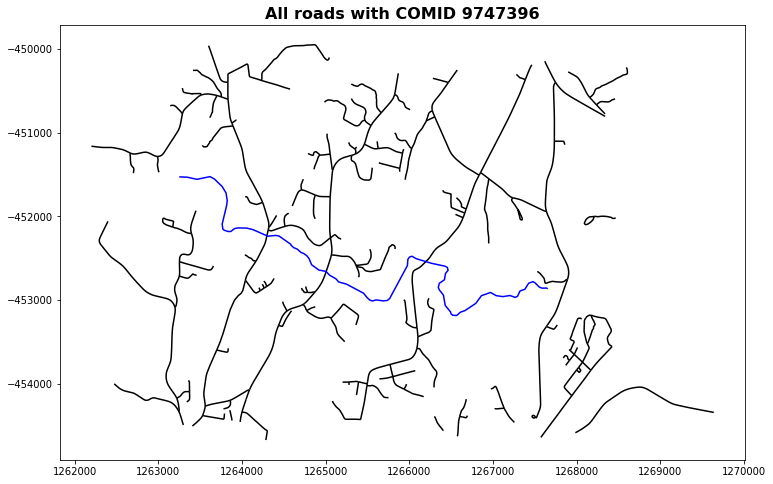

In [6]:
# Show the initial stream and roads
fig, ax = plt.subplots(figsize = (20,8))
gdf_roads.plot(color='k', ax=ax);
stream.plot(color='b', ax=ax);
ax.set_title("All roads with COMID {}".format(comid), fontsize=16, fontweight='bold');

You have 3 intersecting roads.


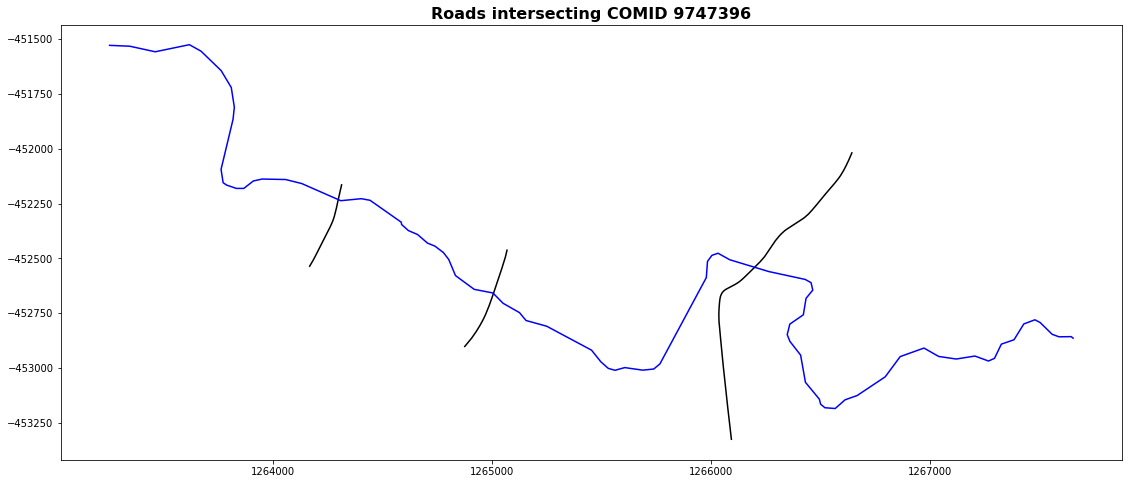

In [7]:
# Filter roads to those that intersect the stream
intersecting_roads = gdf_roads[gdf_roads.geometry.apply(lambda row: stream_shape.intersects(row))]

print("You have {} intersecting roads.".format(len(intersecting_roads)))

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
intersecting_roads.plot(color='k', ax=ax);
stream.plot(color='b', ax=ax);
ax.set_title("Roads intersecting COMID {}".format(comid), fontsize=16, fontweight='bold');

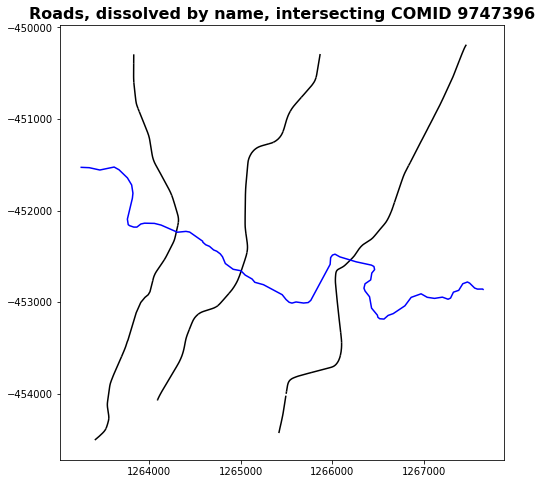

In [8]:
# Dissolve roads by full street name
gdf_roads_diss = gdf_roads.dissolve(by='FULL_STREE')
# Find only roads which intersect streams
intersecting_roads = gdf_roads_diss[gdf_roads_diss.geometry.apply(lambda row: stream_shape.intersects(row))].copy()

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
intersecting_roads.plot(color='k', ax=ax);
stream.plot(color='b', ax=ax);
ax.set_title("Roads, dissolved by name, intersecting COMID {}".format(comid), fontsize=16, fontweight='bold');

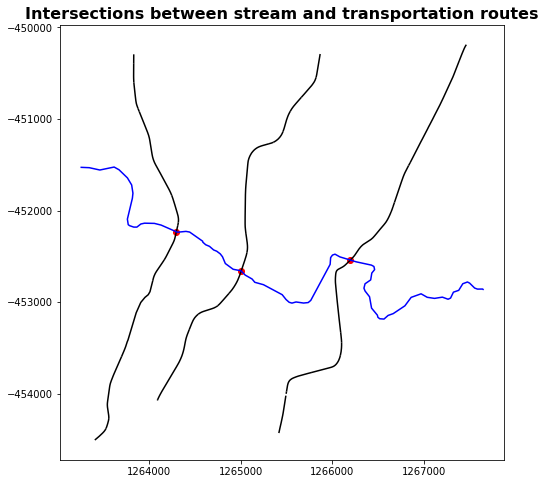

In [9]:
# Find the intersection of transportation routes and streams
intersections = intersecting_roads.geometry.apply(lambda row: stream_shape.intersection(row))

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
intersecting_roads.plot(color='k', ax=ax);
stream.plot(color='b', ax=ax);
intersections.plot(color='r', ax=ax);
ax.set_title("Intersections between stream and transportation routes", fontsize=16, fontweight='bold');

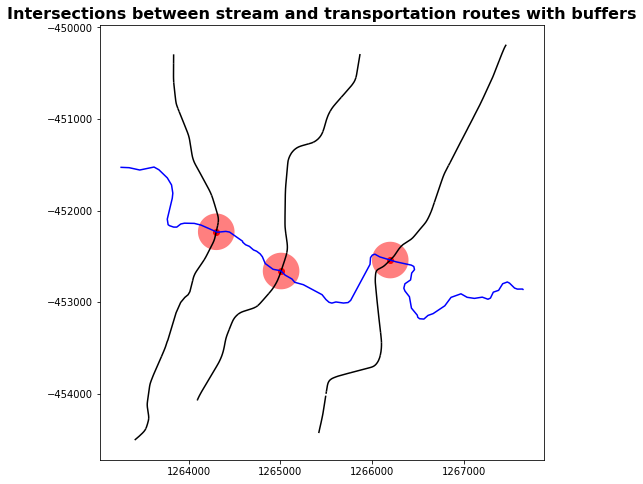

In [10]:
# Apply an arbitrary buffer to intersections
intersection_buffers = intersections.buffer(200)

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
intersecting_roads.plot(color='k', ax=ax);
stream.plot(color='b', ax=ax);
intersections.plot(color='r', ax=ax);
intersection_buffers.plot(color='r', alpha=0.5, ax=ax);
ax.set_title("Intersections between stream and transportation routes with buffers", fontsize=16, fontweight='bold');

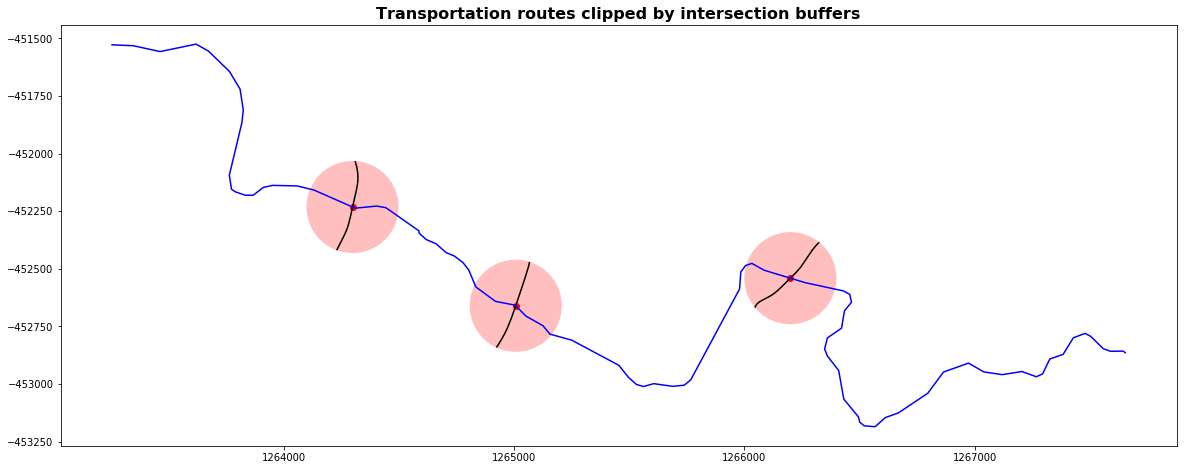

In [11]:
# Roads clipped by intersection buffers
clipped_roads = intersection_buffers.intersection(intersecting_roads)

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
clipped_roads.plot(color='k', ax=ax);
stream.plot(color='b', ax=ax);
intersections.plot(color='r', ax=ax);
intersection_buffers.plot(color='r', alpha=0.25, ax=ax);
ax.set_title("Transportation routes clipped by intersection buffers", fontsize=16, fontweight='bold');

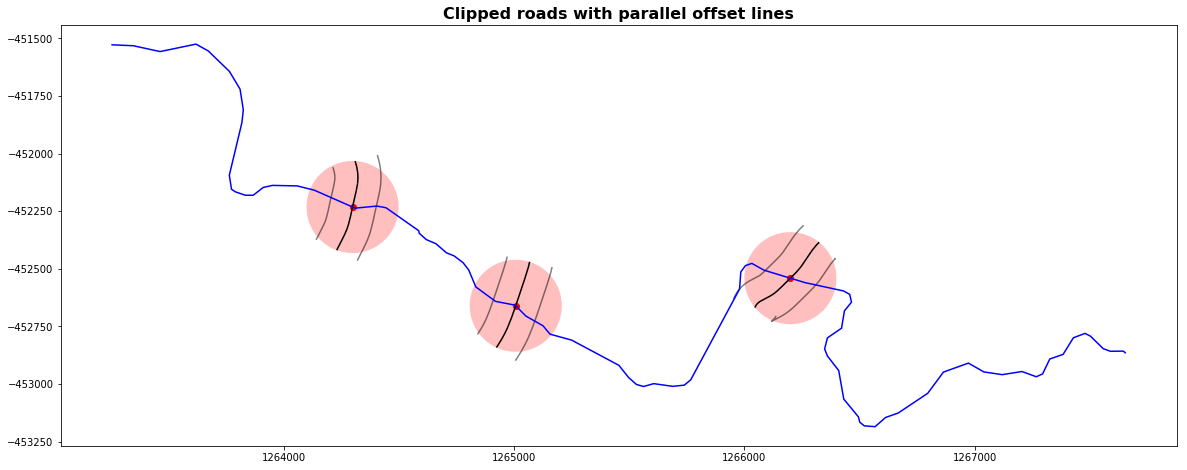

In [12]:
# Create offset lines using shapely parallel offset

# Ensure lines are single-lines
single_lines = []
for road in clipped_roads:
    if type(road) is shapely.geometry.multilinestring.MultiLineString:
        single_lines.append(ops.linemerge(road))
    else:
        single_lines.append(road)

# Create offset lines on right and left sides
offset_lines = []
for side in ['left', 'right']:
    line_list = [line.parallel_offset(100, side) for line in single_lines]
    offset_lines = offset_lines + line_list

# Pull into a GeoDataFrame
gdf_roads = gpd.GeoDataFrame(offset_lines, columns=['geometry'])

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
clipped_roads.plot(color='k', ax=ax);
gdf_roads.plot(color='k', alpha=0.5, ax=ax);
stream.plot(color='b', ax=ax);
intersections.plot(color='r', ax=ax);
intersection_buffers.plot(color='r', alpha=0.25, ax=ax);
ax.set_title("Clipped roads with parallel offset lines", fontsize=16, fontweight='bold');

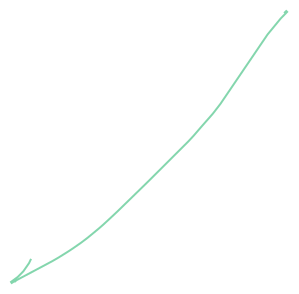

In [13]:
# Note the hooking issue on the third buffer area. The ends of the parallel offset have strange
#     behavor resulting in a hook along the south.
gdf_roads.geometry[4]

In [14]:
# Obtain the vertecies of the offending line
vertecies = [Point(coord) for coord in gdf_roads.geometry[4].coords]

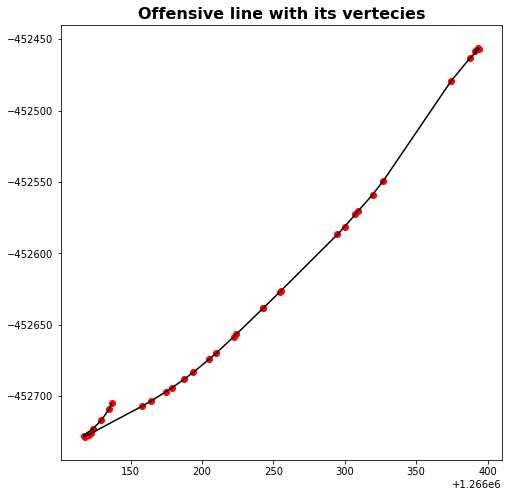

In [15]:
# Plot the offending line with vertecies
bad_road = gpd.GeoDataFrame([gdf_roads.geometry[4]], columns=['geometry'])
bad_vertecies = gpd.GeoDataFrame(vertecies, columns=['geometry'])

fig, ax = plt.subplots(figsize = (20,8))
bad_road.plot(color='k', ax=ax);
bad_vertecies.plot(color='r', ax=ax);
ax.set_title("Offensive line with its vertecies", fontsize=16, fontweight='bold');

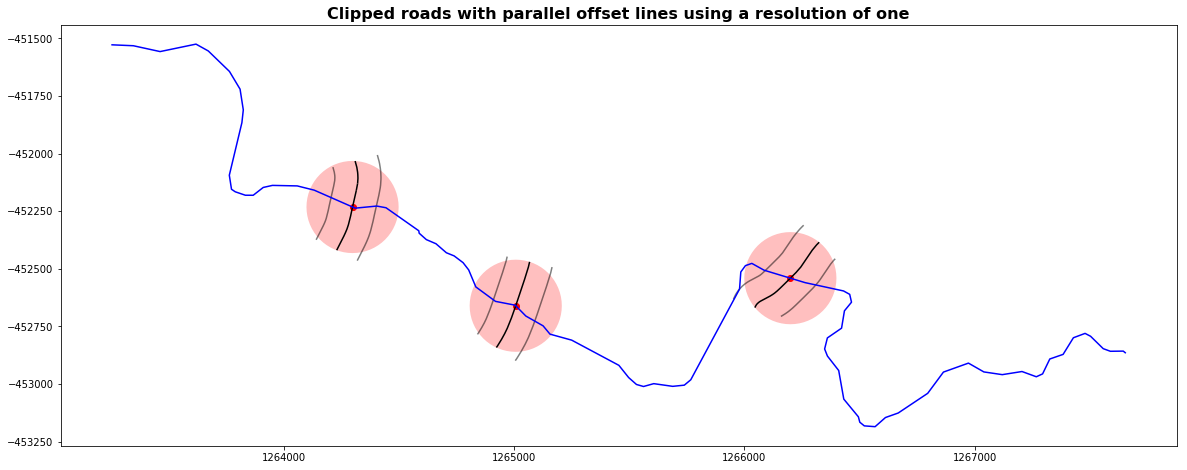

In [16]:
# Resolve the above by setting the resolution to one for parallel offset
offset_lines = []
for side in ['left', 'right']:
    line_list = [line.parallel_offset(100, side, resolution=1) for line in single_lines]
    offset_lines = offset_lines + line_list

# Pull into a GeoDataFrame
gdf_roads = gpd.GeoDataFrame(offset_lines, columns=['geometry'])

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
clipped_roads.plot(color='k', ax=ax);
gdf_roads.plot(color='k', alpha=0.5, ax=ax);
stream.plot(color='b', ax=ax);
intersections.plot(color='r', ax=ax);
intersection_buffers.plot(color='r', alpha=0.25, ax=ax);
ax.set_title("Clipped roads with parallel offset lines using a resolution of one", fontsize=16, fontweight='bold');

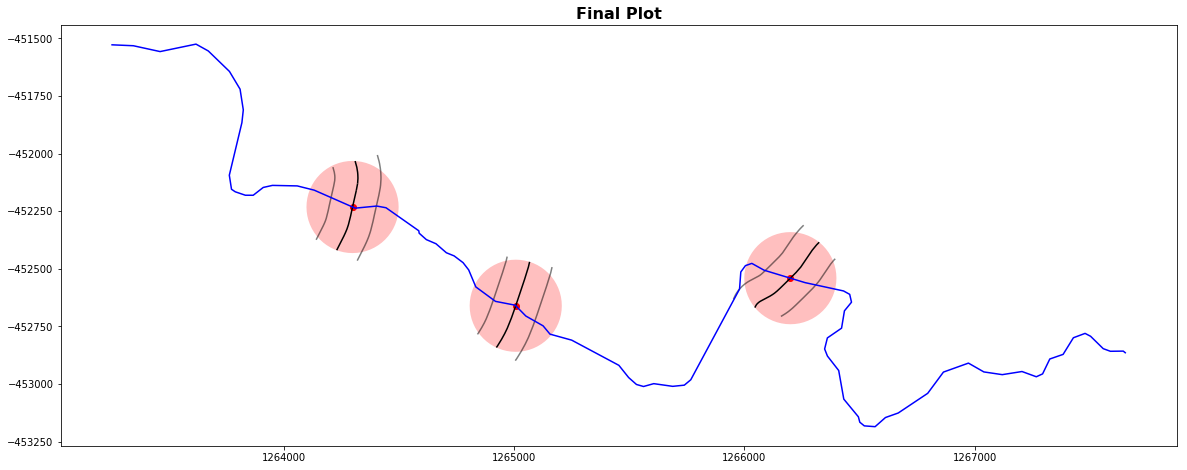

In [19]:
# Pull the above into a single cell
gdf_streams = gpd.read_file(streams)
gdf_roads = gpd.read_file(roads)

stream_prj = gdf_streams.to_crs(gdf_roads.crs)
stream_shape = list(stream_prj.geometry)[0]
gdf_roads_diss = gdf_roads.dissolve(by='FULL_STREE')

intersecting_roads = gdf_roads_diss[gdf_roads_diss.geometry.apply(lambda row: stream_shape.intersects(row))].copy()
intersections = intersecting_roads.geometry.apply(lambda row: stream_shape.intersection(row))
intersection_buffers = intersections.buffer(200)

clipped_roads = intersection_buffers.intersection(intersecting_roads)

single_lines = []
for road in clipped_roads:
    if type(road) is shapely.geometry.multilinestring.MultiLineString:
        single_lines.append(ops.linemerge(road))
    else:
        single_lines.append(road)
        
offset_lines = []
for side in ['left', 'right']:
    line_list = [line.parallel_offset(100, side, resolution=1) for line in single_lines]
    offset_lines = offset_lines + line_list

gdf_roads = gpd.GeoDataFrame(offset_lines, columns=['geometry'])

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
clipped_roads.plot(color='k', ax=ax);
gdf_roads.plot(color='k', alpha=0.5, ax=ax);
stream_prj.plot(color='b', ax=ax);
intersections.plot(color='r', ax=ax);
intersection_buffers.plot(color='r', alpha=0.25, ax=ax);
ax.set_title("Final Plot", fontsize=16, fontweight='bold');

Current development will proceed towards creating profiles.

Future avenues for work include:
1. Varying the buffer width based on local topography. For example, extend buffer radius until elevation along parallel offset line is within some percentage of the road elevation.
1. Vary the parallel offset distance based on transportation classification or topographic signal.
1. Ensure parallel offset line does not interset the streamline.

# END